In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Merge, Concatenate, Reshape, Softmax
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import isolearn_keras as iso

from aparent_losses import *


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

def letterAt(letter, x, y, yscale=1, ax=None, color=None, alpha=1.0):

    #fp = FontProperties(family="Arial", weight="bold")
    fp = FontProperties(family="Ubuntu", weight="bold")
    globscale = 1.35
    LETTERS = {	"T" : TextPath((-0.305, 0), "T", size=1, prop=fp),
                "G" : TextPath((-0.384, 0), "G", size=1, prop=fp),
                "A" : TextPath((-0.35, 0), "A", size=1, prop=fp),
                "C" : TextPath((-0.366, 0), "C", size=1, prop=fp),
                "UP" : TextPath((-0.488, 0), '$\\Uparrow$', size=1, prop=fp),
                "DN" : TextPath((-0.488, 0), '$\\Downarrow$', size=1, prop=fp),
                "(" : TextPath((-0.25, 0), "(", size=1, prop=fp),
                "." : TextPath((-0.125, 0), "-", size=1, prop=fp),
                ")" : TextPath((-0.1, 0), ")", size=1, prop=fp)}
    COLOR_SCHEME = {'G': 'orange', 
                    'A': 'red', 
                    'C': 'blue', 
                    'T': 'darkgreen',
                    'UP': 'green', 
                    'DN': 'red',
                    '(': 'black',
                    '.': 'black', 
                    ')': 'black'}


    text = LETTERS[letter]

    chosen_color = COLOR_SCHEME[letter]
    if color is not None :
        chosen_color = color

    t = mpl.transforms.Affine2D().scale(1*globscale, yscale*globscale) + \
        mpl.transforms.Affine2D().translate(x,y) + ax.transData
    p = PathPatch(text, lw=0, fc=chosen_color, alpha=alpha, transform=t)
    if ax != None:
        ax.add_artist(p)
    return p

def plot_seqprop_logo(pwm, iso_pred, cut_pred, annotate_peaks=None, sequence_template=None, figsize=(12, 3), width_ratios=[1, 7], logo_height=1.0, usage_unit='log', plot_start=0, plot_end=164, save_figs=False, fig_name=None, fig_dpi=300) :

    n_samples = pwm.shape[0]
    
    #Slice according to seq trim index
    pwm = pwm[:, plot_start: plot_end, :]
    cut_pred = cut_pred[:, plot_start: plot_end]
    sequence_template = sequence_template[plot_start: plot_end]
    
    iso_pred = np.mean(iso_pred, axis=0)
    cut_pred = np.mean(cut_pred, axis=0)
    pwm = np.sum(pwm, axis=0)
    
    pwm += 0.0001
    for j in range(0, pwm.shape[0]) :
        pwm[j, :] /= np.sum(pwm[j, :])
    
    entropy = np.zeros(pwm.shape)
    entropy[pwm > 0] = pwm[pwm > 0] * -np.log2(pwm[pwm > 0])
    entropy = np.sum(entropy, axis=1)
    conservation = 2 - entropy

    fig = plt.figure(figsize=figsize)
    
    gs = gridspec.GridSpec(2, 2, width_ratios=[width_ratios[0], width_ratios[-1]], height_ratios=[1, 1])
    
    ax0 = plt.subplot(gs[0, 0])
    ax1 = plt.subplot(gs[0, 1])
    ax2 = plt.subplot(gs[1, 0])
    ax3 = plt.subplot(gs[1, 1])
    
    plt.sca(ax0)
    plt.axis('off')
    plt.sca(ax2)
    plt.axis('off')
    
    
    annot_text = 'Samples = ' + str(int(n_samples))
    annot_text += '\nUsage = ' + str(round(np.sum(cut_pred), 4))
        
    ax2.text(0.99, 0.5, annot_text, horizontalalignment='right', verticalalignment='center', transform=ax2.transAxes, color='black', fontsize=12, weight="bold")

    l2, = ax1.plot(np.arange(plot_end - plot_start), cut_pred, linewidth=3, linestyle='-', label='Predicted', color='red', alpha=0.7)
    
    if annotate_peaks is not None :
        objective_pos = 0
        if annotate_peaks == 'max' :
            objective_pos = np.argmax(cut_pred)
        else :
            objective_pos = annotate_peaks - plot_start
        
        annot_text = '(CSE+' + str(objective_pos + plot_start - 76 + 1) + ') ' + str(int(round(cut_pred[objective_pos] * 100, 0))) + '% Cleavage'
        ax1.annotate(annot_text, xy=(objective_pos, cut_pred[objective_pos]), xycoords='data', xytext=(-30, -5), ha='right', fontsize=10, weight="bold", color='black', textcoords='offset points', arrowprops=dict(connectionstyle="arc3,rad=-.1", headlength=8, headwidth=8, shrink=0.15, width=1.5, color='black'))
    
    plt.sca(ax1)

    plt.xlim((0, plot_end - plot_start))
    #plt.ylim((0, 2))
    plt.xticks([], [])
    plt.yticks([], [])
    plt.legend(handles=[l2], fontsize=12, prop=dict(weight='bold'), frameon=False)
    plt.axis('off')
    
    height_base = (1.0 - logo_height) / 2.

    for j in range(0, pwm.shape[0]) :
        sort_index = np.argsort(pwm[j, :])

        for ii in range(0, 4) :
            i = sort_index[ii]

            nt_prob = pwm[j, i] * conservation[j]

            nt = ''
            if i == 0 :
                nt = 'A'
            elif i == 1 :
                nt = 'C'
            elif i == 2 :
                nt = 'G'
            elif i == 3 :
                nt = 'T'

            color = None
            if sequence_template[j] != 'N' :
                color = 'black'

            if ii == 0 :
                letterAt(nt, j + 0.5, height_base, nt_prob * logo_height, ax3, color=color)
            else :
                prev_prob = np.sum(pwm[j, sort_index[:ii]] * conservation[j]) * logo_height
                letterAt(nt, j + 0.5, height_base + prev_prob, nt_prob * logo_height, ax3, color=color)

    #ax[0].plot([0, pwm.shape[0]], [0, 1], color='black', linestyle='--')

    plt.sca(ax3)

    plt.xlim((0, plot_end - plot_start))
    plt.ylim((0, 2))
    plt.xticks([], [])
    plt.yticks([], [])
    plt.axis('off')
    ax3.axhline(y=0.01 + height_base, color='black', linestyle='-', linewidth=2)


    for axis in fig.axes :
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)
    
    plt.tight_layout()
    
    if save_figs :
        plt.savefig(fig_name + '.png', transparent=True, dpi=fig_dpi)
        plt.savefig(fig_name + '.svg')
        plt.savefig(fig_name + '.eps')
    
    plt.show()

In [3]:
from tensorflow.python.framework import ops

def st_sampled_softmax(logits):
    """Takes logits and samples a one-hot vector according to them, using the straight
    through estimator on the backward pass."""
    with ops.name_scope("STSampledSoftmax") as name:
        probs = tf.nn.softmax(logits)
        onehot_dims = logits.get_shape().as_list()[1]
        res = tf.one_hot(tf.squeeze(tf.multinomial(logits, 1), 1), onehot_dims, 1.0, 0.0)
        with tf.get_default_graph().gradient_override_map({'Ceil': 'Identity', 'Mul': 'STMul'}):
            return tf.ceil(res*probs)

def st_hardmax_softmax(logits):
    """Takes logits and creates a one-hot vector with a 1 in the position of the maximum
    logit, using the straight through estimator on the backward pass."""
    with ops.name_scope("STHardmaxSoftmax") as name:
        probs = tf.nn.softmax(logits)
        onehot_dims = logits.get_shape().as_list()[1]
        res = tf.one_hot(tf.argmax(probs, 1), onehot_dims, 1.0, 0.0)
        with tf.get_default_graph().gradient_override_map({'Ceil': 'Identity', 'Mul': 'STMul'}):
            return tf.ceil(res*probs)

@ops.RegisterGradient("STMul")
def st_mul(op, grad):
    """Straight-through replacement for Mul gradient (does not support broadcasting)."""
    return [grad, grad]


In [24]:
def mask_pwm(inputs) :
    pwm, onehot_template, onehot_mask = inputs

    return pwm * onehot_mask + onehot_template

def sample_pwm(pwm_logits) :
    n_sequences = pwm_logits.get_shape().as_list()[0]
    seq_length = pwm_logits.get_shape().as_list()[1]
    
    flat_pwm = K.reshape(pwm_logits, (n_sequences * seq_length, 4))
    sampled_pwm = K.switch(K.learning_phase(), st_sampled_softmax(flat_pwm), st_hardmax_softmax(flat_pwm))

    return K.reshape(sampled_pwm, (n_sequences, seq_length, 4, 1))

def load_seqprop_model(n_sequences, n_samples) :
    
    #APARENT parameters
    seq_length = 205
    seq_input_shape = (205, 4, 1)
    lib_input_shape = (n_sequences * n_samples, 13)
    distal_pas_shape = (n_sequences * n_samples, 1)
    num_outputs_iso = 1
    num_outputs_cut = 206
    
    
    reshape_layer = Lambda(lambda x: K.reshape(x, (n_sequences, seq_length, 4, 1)), name='onehot_reshape')
    
    onehot_template_dense = Dense(n_sequences * seq_length * 4, use_bias=False, kernel_initializer='zeros', name='template_dense')
    onehot_mask_dense = Dense(n_sequences * seq_length * 4, use_bias=False, kernel_initializer='ones', name='mask_dense')
    
    ones_input = Input(tensor=K.ones((1, 1)), name='seed_input')
    
    
    onehot_template = reshape_layer(onehot_template_dense(ones_input))
    onehot_mask = reshape_layer(onehot_mask_dense(ones_input))
    
    
    dense_seq_layer = Dense(n_sequences * seq_length * 4, use_bias=False, kernel_initializer='glorot_uniform', name='policy_pwm')
    

    pwm_layer = Lambda(mask_pwm, output_shape = seq_input_shape)
    pwm_logits = pwm_layer([reshape_layer(dense_seq_layer(ones_input)), onehot_template, onehot_mask])
    
    pwm = Softmax(axis=-2, name='pwm')(pwm_logits)
    
    pwm_logit_samples = Lambda(lambda pwm: K.tile(pwm, [n_samples, 1, 1, 1]))(pwm_logits)
    
    sampled_pwm = Lambda(sample_pwm, name='pwm_sampler')(pwm_logit_samples)
    
    
    #Shared model definition
    layer_1 = Conv2D(96, (8, 4), padding='valid', activation='relu', name='aparent_conv_1')
    layer_1_pool = MaxPooling2D(pool_size=(2, 1))
    layer_2 = Conv2D(128, (6, 1), padding='valid', activation='relu', name='aparent_conv_2')
    layer_dense = Dense(512, activation='relu', name='aparent_dense_1')
    layer_drop = Dropout(0.2)
    layer_dense2 = Dense(256, activation='relu', name='aparent_dense_2')
    layer_drop2 = Dropout(0.2)

    def shared_model(seq_input, distal_pas_input) :
        return layer_drop2(
                    layer_dense2(
                        layer_drop(
                            layer_dense(
                                Concatenate()([
                                    Flatten()(
                                        layer_2(
                                            layer_1_pool(
                                                layer_1(
                                                    seq_input
                                                )
                                            )
                                        )
                                    ),
                                    distal_pas_input
                                ])
                            ), training=False
                        )
                    ), training=False
                )

    
    #Plasmid model definition
    lib_input = Input(tensor=K.zeros(lib_input_shape))
    distal_pas_input = Input(tensor=K.ones(distal_pas_shape))

    #Outputs
    plasmid_out_shared = Concatenate()([shared_model(sampled_pwm, distal_pas_input), lib_input])

    plasmid_score_cut = Dense(num_outputs_cut, kernel_initializer='zeros', name='aparent_cut_dense')(plasmid_out_shared)
    plasmid_score_iso = Dense(num_outputs_iso, kernel_initializer='zeros', name='aparent_iso_dense')(plasmid_out_shared)
    
    plasmid_out_cut = Softmax(axis=-1)(plasmid_score_cut)
    plasmid_out_iso = Dense(num_outputs_iso, activation='sigmoid', kernel_initializer='ones', use_bias=False)(plasmid_score_iso)
    
    cut_reshape = Lambda(lambda x: K.reshape(x, (n_samples, n_sequences, num_outputs_cut)))
    iso_reshape = Lambda(lambda x: K.reshape(x, (n_samples, n_sequences, num_outputs_iso)))
    
    sample_out_iso = iso_reshape(plasmid_out_iso)
    sample_out_cut = cut_reshape(plasmid_out_cut)
    sample_score_iso = iso_reshape(plasmid_score_iso)
    sample_score_cut = cut_reshape(plasmid_score_cut)
    
    plasmid_model = Model(
        inputs=[
            ones_input,
            lib_input,
            distal_pas_input
        ],
        outputs=[
            pwm,
            sample_out_iso,
            sample_out_cut,
            sample_score_iso,
            sample_score_cut
        ]
    )

    return 'plasmid_iso_cut_distalpas_large', plasmid_model

In [15]:
#Load pre-trained model
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'aparent_plasmid_iso_cut_distalpas_large_all_libs.h5'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)

saved_model = load_model(model_path)

/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [25]:
#Seqprop architecture sandbox
_, seqprop_model = load_seqprop_model(8, 4)

seqprop_model.get_layer('aparent_conv_1').set_weights(saved_model.get_layer('conv2d_1').get_weights())
seqprop_model.get_layer('aparent_conv_1').trainable = False

seqprop_model.get_layer('aparent_conv_2').set_weights(saved_model.get_layer('conv2d_2').get_weights())
seqprop_model.get_layer('aparent_conv_2').trainable = False

seqprop_model.get_layer('aparent_dense_1').set_weights(saved_model.get_layer('dense_1').get_weights())
seqprop_model.get_layer('aparent_dense_1').trainable = False

seqprop_model.get_layer('aparent_dense_2').set_weights(saved_model.get_layer('dense_2').get_weights())
seqprop_model.get_layer('aparent_dense_2').trainable = False

seqprop_model.get_layer('aparent_cut_dense').set_weights(saved_model.get_layer('dense_3').get_weights())
seqprop_model.get_layer('aparent_cut_dense').trainable = False

seqprop_model.get_layer('aparent_iso_dense').set_weights(saved_model.get_layer('dense_4').get_weights())
seqprop_model.get_layer('aparent_iso_dense').trainable = False

for seqprop_layer in seqprop_model.layers :
    seqprop_layer.trainable = False
    
    if 'policy' in seqprop_layer.name :
        seqprop_layer.trainable = True


In [26]:
n_sequences = 8
n_samples = 4

#Make template and mask matrices
sequence_template = 'GCTCTTCCGATCTTAGTGCTCTCACGTCTGNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNTTAAGCCTGTCTGTACACACGCCTCCCCTTTCAAATAAATGCCATACCTACAGTGTCTTCATACTCTGAGTCTAACACCT'[:205]
#sequence_template = 'NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAAXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'[:205]


onehot_template = iso.OneHotEncoder(seq_length=len(sequence_template))(sequence_template).reshape((1, len(sequence_template), 4, 1))
onehot_template = np.tile(onehot_template, (n_sequences, 1, 1, 1))

#onehot_template[onehot_template > 0] = 10.
#onehot_template[onehot_template == 0] = -4

for j in range(len(sequence_template)) :
    if sequence_template[j] != 'N' :
        if sequence_template[j] != 'X' :
            nt_ix = np.argmax(onehot_template[0, j, :, 0])
            onehot_template[:, j, :, :] = -4
            onehot_template[:, j, nt_ix, :] = 10
        else :
            onehot_template[:, j, :, :] = -1

onehot_mask = np.zeros((n_sequences, len(sequence_template), 4, 1))
for j in range(len(sequence_template)) :
    if sequence_template[j] == 'N' :
        onehot_mask[:, j, :, :] = 1.0


seqprop_model.get_layer('template_dense').set_weights([onehot_template.reshape(1, -1)])
seqprop_model.get_layer('template_dense').trainable = False

seqprop_model.get_layer('mask_dense').set_weights([onehot_mask.reshape(1, -1)])
seqprop_model.get_layer('mask_dense').trainable = False


In [30]:
#Objective model definition

def mean_target_conservation_mse(pwm, target_conservation=2.0) :
    pwm_section = pwm[:, 70-40:70+50, :, :]
    entropy = pwm_section * -K.log(K.clip(pwm_section, K.epsilon(), 1. - K.epsilon())) / K.log(2.0)
    entropy = K.sum(entropy, axis=(2, 3))
    conservation = 2.0 - entropy
    
    return K.mean((conservation - target_conservation)**2, axis=-1)

def punish_dn_cse(pwm) :
    
    aataaa_score = K.sum(pwm[:, 74:-5, 0, 0] * pwm[:, 75:-4, 0, 0] * pwm[:, 76:-3, 3, 0] * pwm[:, 77:-2, 0, 0] * pwm[:, 78:-1, 0, 0] * pwm[:, 79:, 0, 0], axis=-1)
    attaaa_score = K.sum(pwm[:, 74:-5, 0, 0] * pwm[:, 75:-4, 3, 0] * pwm[:, 76:-3, 3, 0] * pwm[:, 77:-2, 0, 0] * pwm[:, 78:-1, 0, 0] * pwm[:, 79:, 0, 0], axis=-1)
    
    return aataaa_score + attaaa_score

def punish_up_cse(pwm) :
    
    aataaa_score = K.sum(pwm[:, :65, 0, 0] * pwm[:, 1:66, 0, 0] * pwm[:, 2:67, 3, 0] * pwm[:, 3:68, 0, 0] * pwm[:, 4:69, 0, 0] * pwm[:, 5:70, 0, 0], axis=-1)
    attaaa_score = K.sum(pwm[:, :65, 0, 0] * pwm[:, 1:66, 3, 0] * pwm[:, 2:67, 3, 0] * pwm[:, 3:68, 0, 0] * pwm[:, 4:69, 0, 0] * pwm[:, 5:70, 0, 0], axis=-1)
    
    return aataaa_score + attaaa_score

def kl_divergence(y_true, y_pred) :
    y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
    y_true = K.clip(y_true, K.epsilon(), 1. - K.epsilon())
    
    return K.sum(y_true * K.log(y_true / y_pred), axis=-1)

def symmetric_kl_divergence(y_true, y_pred) :
    y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
    y_true = K.clip(y_true, K.epsilon(), 1. - K.epsilon())
    
    return K.sum(y_true * K.log(y_true / y_pred), axis=-1) + K.sum(y_pred * K.log(y_pred / y_true), axis=-1)



#Specify objective
target_cuts = np.zeros((n_samples, n_sequences, 206))
target_cuts[:, :, 110] = 1.0

target_input = Input(tensor=K.constant(target_cuts, shape=(n_samples, n_sequences, 206)))


objective_func = Lambda(
    #lambda out: K.sum(-out[4][:, 110] + 0.1 * punish_dn_cse(out[0]) + 0.5 * mean_target_conservation_mse(out[0], target_conservation=1.8), axis=0),
    #lambda out: 1.0 * kl_divergence(out[-1], out[2]) + 1.0 * punish_dn_cse(out[0]) + 0.5 * mean_target_conservation_mse(out[0], target_conservation=1.8),
    
    
    lambda out: K.sum(1.0 * K.mean(kl_divergence(out[-1], out[2]), axis=0) + 1.0 * punish_dn_cse(out[0]) + 0.5 * mean_target_conservation_mse(out[0], target_conservation=1.8), axis=0),
    
    
    
    output_shape = (1,)
)(
    seqprop_model.outputs + [target_input]
)

objective_model = Model(seqprop_model.inputs + [target_input], objective_func)

In [31]:
#(Re-)Initialize PWM weights
seqprop_model.layers[1].kernel.initializer.run(session=K.get_session())

In [ ]:
#Manually initialize pwm logits

init_template = 'TTTTCCTCCCCCACCAGGACGCTCTCGTTTTGTCGTTTATTTTTAATTTTATGTACCCCCCCTTTTTTTT'

seqprop_weights = seqprop_model.layers[1].get_weights()[0]

for j in range(len(init_template)) :
    if init_template[j] == 'A' :
        seqprop_weights[0, j * 4 + 0] = 0.2
        seqprop_weights[0, j * 4 + 1] = -0.2
        seqprop_weights[0, j * 4 + 2] = -0.2
        seqprop_weights[0, j * 4 + 3] = -0.2
    elif init_template[j] == 'C' :
        seqprop_weights[0, j * 4 + 0] = -0.2
        seqprop_weights[0, j * 4 + 1] = 0.2
        seqprop_weights[0, j * 4 + 2] = -0.2
        seqprop_weights[0, j * 4 + 3] = -0.2
    elif init_template[j] == 'G' :
        seqprop_weights[0, j * 4 + 0] = -0.2
        seqprop_weights[0, j * 4 + 1] = -0.2
        seqprop_weights[0, j * 4 + 2] = 0.2
        seqprop_weights[0, j * 4 + 3] = -0.2
    elif init_template[j] == 'T' :
        seqprop_weights[0, j * 4 + 0] = -0.2
        seqprop_weights[0, j * 4 + 1] = -0.2
        seqprop_weights[0, j * 4 + 2] = -0.2
        seqprop_weights[0, j * 4 + 3] = 0.2

seqprop_model.layers[1].set_weights([seqprop_weights])

In [32]:
opt = keras.optimizers.SGD(lr=0.5)
#opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

objective_model.compile(loss=lambda true, pred: pred, optimizer=opt)

callbacks =[
    EarlyStopping(monitor='loss', min_delta=0.001, patience=2, verbose=0, mode='auto')
]

train_history = objective_model.fit([], np.ones((1, 1)),
                    epochs=20,
                    steps_per_epoch=500,
                    callbacks=callbacks)


Epoch 1/20
500/500 [==============================] - 18s 36ms/step - loss: 25.9339
Epoch 2/20
500/500 [==============================] - 18s 35ms/step - loss: 19.6611
Epoch 3/20
500/500 [==============================] - 19s 38ms/step - loss: 18.8767
Epoch 4/20
500/500 [==============================] - 19s 39ms/step - loss: 18.5472
Epoch 5/20
500/500 [==============================] - 22s 44ms/step - loss: 18.3282
Epoch 6/20
500/500 [==============================] - 24s 47ms/step - loss: 18.2794
Epoch 7/20
500/500 [==============================] - 20s 39ms/step - loss: 18.2283
Epoch 8/20
500/500 [==============================] - 20s 41ms/step - loss: 18.1908
Epoch 9/20
500/500 [==============================] - 20s 41ms/step - loss: 18.0912
Epoch 10/20
500/500 [==============================] - 20s 40ms/step - loss: 18.1060
Epoch 11/20
500/500 [==============================] - 20s 39ms/step - loss: 18.1596


In [33]:
optimized_pwm, iso_pred, cut_pred, iso_score_pred, cut_score_pred = seqprop_model.predict(x=None, steps=1)

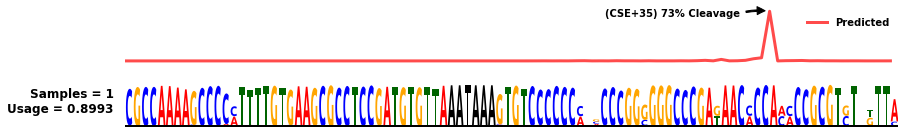

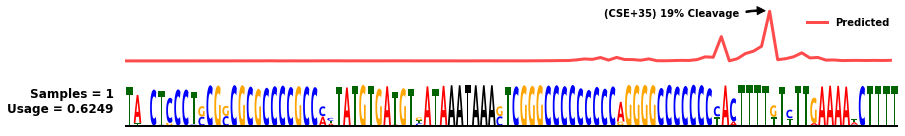

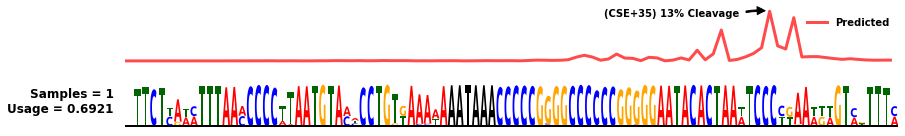

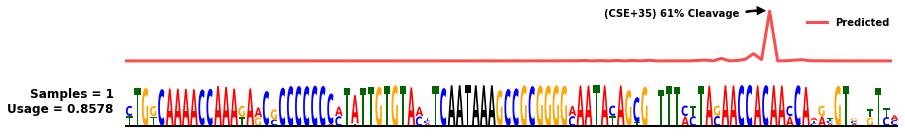

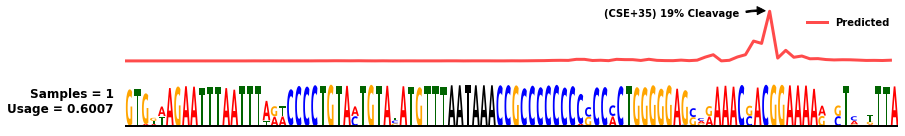

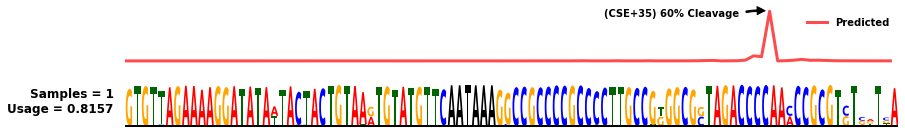

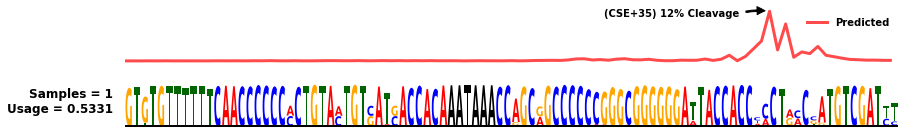

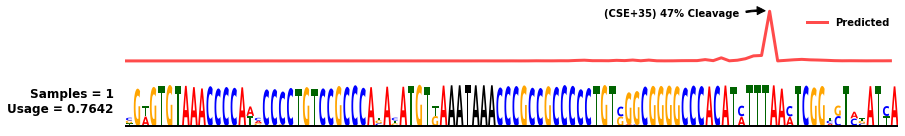

In [34]:
plot_start = 70-40
plot_end = 76+50

for pwm_index in range(8) :
    plot_seqprop_logo(np.expand_dims(optimized_pwm[pwm_index, :, :, 0], axis=0), np.expand_dims(iso_pred[0, pwm_index, :], axis=0), np.expand_dims(cut_pred[0, pwm_index, :], axis=0), annotate_peaks='max', sequence_template=sequence_template, figsize=(13, 2), width_ratios=[1, 8], logo_height=0.8, usage_unit='log', plot_start=plot_start, plot_end=plot_end, save_figs=False, fig_name=None, fig_dpi=300)